In [8]:
# !pip install torch -U
# !pip install faiss-cpu -U

In [ ]:
# !pip install imagehash pillow annoy

In [ ]:
# !pip install sentence-transformers

In [ ]:
# !conda install -c intel mkl

# О поиске объектов

*Подготовил Ян Пиле*

Картиночка для привлечения внимания ))

Как это называется?
<img src = "https://habrastorage.org/r/w1560/webt/8x/ue/vk/8xuevk8kk8l-99kjyhxh3rktk6s.jpeg">

# Метод k ближайших соседей

In [1]:
import requests
import warnings
import numpy as np
import pandas as pd
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import neighbors
from sentence_transformers import SentenceTransformer



warnings.filterwarnings("ignore")

/Users/i.pile/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Ирисы Фишера

Спер [отсюда](https://kirenz.github.io/classification/docs/knn-iris.html)

In [1]:
iris = datasets.load_iris()
print(iris.keys())

NameError: name 'datasets' is not defined

Для простоты взяли двумерное пространство

In [ ]:
n_samples, n_features = iris.data.shape

print((n_samples, n_features))

In [ ]:
x_index = 0
y_index = 1

# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(iris.data[:, x_index], 
            iris.data[:, y_index],
            c=iris.target, 
            cmap=plt.cm.get_cmap('RdYlBu', 3))
            
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.clim(-0.5, 2.5)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index]);

In [ ]:
# plt.cm.get_cmap??

In [ ]:
X, y = iris.data, iris.target

clf = neighbors.KNeighborsClassifier(n_neighbors=5)

clf.fit(X, y)

## Вы нашли ирис с параметрами:

Чашелистик 3cm x 5cm  и Лепестки 4cm x 2cm, что за вид Ирисов?

In [ ]:
result = clf.predict([[3, 5, 4, 2],])

print(iris.target_names[result])

In [ ]:
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_iris_knn():
    iris = datasets.load_iris()
    X = iris.data[:, :2]  # we only take the first two features.
    y = iris.target

    knn = neighbors.KNeighborsClassifier(n_neighbors=3)
    knn.fit(X, y)

    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    pl.figure()
    pl.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    pl.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    pl.xlabel('sepal length (cm)')
    pl.ylabel('sepal width (cm)')
    pl.axis('tight')
    
plot_iris_knn()

Интересная штука в том, что для классификации вы делаете следующее:
    
    1) Берете точку
    2) Кидаете ее на свое пространство параметров
    3) Смотрите k соседей и простым голосованием выбираете ответ

# Какая будет сложность поиска k соседей?

Ответ – ТОЛСТАЯ

Конечно же более интересным было бы брать какие-то объекты, генерировать их векторное представление, а уже дальше смотреть на то, какие из векторов наиболее близки к нашему конкретному примеру. Погнали смотреть :)

### Есть 4 предложения

In [2]:
data = [['Where are your headquarters located?', 'location'],
['Throw my cellphone in the water', 'random'],
['Network Access Control?', 'networking'],
['Address', 'location']]
df = pd.DataFrame(data, columns = ['text', 'category'])
df

,text,category
0,Where are your headquarters located?,location
1,Throw my cellphone in the water,random
2,Network Access Control?,networking
3,Address,location


Возьму нейронку (уже обученную), да и закодирую эти предложения :)

In [3]:
text = df['text']
encoder = SentenceTransformer("paraphrase-mpnet-base-v2")
vectors = encoder.encode(text)

In [4]:
# Длина вектора

len(vectors[0])

768

# Ну а теперь вместо sklearn заиспользуем библиотеку от Facebook

In [7]:
import faiss

# Размер вектора
vector_dimension = vectors.shape[1]

# Сделали "плоский" индекс размера 768
index = faiss.IndexFlatL2(vector_dimension)


In [8]:

# Векторы нормализовали
faiss.normalize_L2(vectors)

# Закинули весь наш списочек в индекс
index.add(vectors)

## Какой еще индекс?

По сути, это просто набор параметров и векторов. Наборы параметров бывают разные и зависят от нужд пользователя. Векторы могут оставаться неизменными, а могут перестраиваться. Некоторые индексы доступны для работы сразу после добавления в них векторов, а некоторые требуют предварительного обучения. Имена векторов хранятся в индексе: либо в нумерации от 0 до n, либо в виде числа, влезающего в тип Int64.

Первый индекс, и самый простой,  – это Flat. Он лишь хранит в себе все вектора, а поиск по заданному вектору осуществляется полным перебором, поэтому обучать его не нужно. На маленьком объеме данных такой простой индекс может вполне покрыть нужды поиска.

In [9]:
search_text = 'where is your office?'
search_vector = encoder.encode(search_text)
_vector = np.array([search_vector])
faiss.normalize_L2(_vector)

In [10]:
k = index.ntotal
distances, ann = index.search(_vector, 
                              k=k)

In [11]:
results = pd.DataFrame({'distances': distances[0], 'ann': ann[0]})

In [12]:
results

,distances,ann
0,0.584873,0
1,1.175950,3
2,1.644265,2
3,1.919767,1


## Наши расстояния

    до фразы 'where is your office?'


In [13]:
pd.merge(results, df, left_on = 'ann', right_index = True)

,distances,ann,text,category
0,0.584873,0,Where are your headquarters located?,location
1,1.175950,3,Address,location
2,1.644265,2,Network Access Control?,networking
3,1.919767,1,Throw my cellphone in the water,random


# Еще примеров Богу примеров

In [14]:
res = requests.get('https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/sick2014/SICK_train.txt')

# Делаем датафрейм
data = pd.read_csv(StringIO(res.text), sep='\t')
data.head()

,pair_ID,sentence_A,sentence_B,relatedness_score,entailment_judgment
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL


In [15]:
data.loc[5].sentence_B

'Two dogs are wrestling and hugging'

In [16]:
data.shape

(4500, 5)

In [17]:
# Берем все уникальные предложения отсюда

sentences = data['sentence_A'].tolist()
sentence_b = data['sentence_B'].tolist()
sentences.extend(sentence_b)  # соединили 
len(set(sentences))

4802

### Маловато, надо больше примеров

In [18]:
urls = [
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/MSRpar.train.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/MSRpar.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/OnWN.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2013/OnWN.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2014/OnWN.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2014/images.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2015/images.test.tsv'
]

In [21]:
# Все датасеты одинаковые +- , поэтому можно циклом
for url in urls:
    res = requests.get(url)
    # Взяли df
    data = pd.read_csv(StringIO(res.text), sep='\t', header=None, on_bad_lines='skip')
    # Заложили список предложений
    sentences.extend(data[1].tolist())
    sentences.extend(data[2].tolist())

In [22]:
# drop duplicates and NaN
sentences = [word for word in list(set(sentences)) if type(word) is str]

In [23]:
len(sentences)

14504

In [27]:
# Инициализируем нейронку-кодировщик
model = SentenceTransformer('bert-base-nli-mean-tokens')

print('Initialized')
# Делаем вектора
sentence_embeddings = model.encode(sentences, show_progress_bar = True)
sentence_embeddings.shape

Initialized


Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [04:46<00:00,  1.59it/s]


(14504, 768)

# IndexFlatL2

IndexFlatL2 измеряет L2 (Евклидово) расстояние между ВСЕМИ векторами и нашим вектором запроса, векторы напрямую грузятся в индекс. Он простой, очень точный и весьма медленный

<img src = "https://d33wubrfki0l68.cloudfront.net/41b688a9c9bee390768e086d7542e3aeac1127df/75506/images/faiss2.png">

In [ ]:
d = sentence_embeddings.shape[1]
d

Часто мы будем использовать индексы, которые требуют обучения перед загрузкой данных. Мы можем проверить, нужно ли обучать индекс, используя метод `is_trained`. 
`IndexFlatL2` не требует обучения.
Векторы загружаем так:

In [ ]:
index = faiss.IndexFlatL2(d)
index.is_trained

In [ ]:
index.add(sentence_embeddings)
index.ntotal  # Кол-во эмбеддингов в индексе

In [ ]:
index

Ищем по запросу `xq` и количеству ближайших соседей `k`.

In [ ]:
k = 4
xq = model.encode(["Someone sprints with a football"])

In [ ]:
# xq

In [ ]:
%%time
D, I = index.search(xq, k)  # search

In [ ]:
# Индексы наиболее близких
I

In [ ]:
data = pd.DataFrame()
data['text'] = sentences

In [ ]:
data.iloc[[ 9525, 11640, 13575,  2977]].values.tolist()

## Можно возвращать сами векторы тоже

In [ ]:
# надо 4 (k) вектора вернуть - инициализируем массив нулей 
vecs = np.zeros((k, d))

# итерируемся по ID из I и добавляем наш вектор к исходному списочку нулей
for i, val in enumerate(I[0].tolist()):
    vecs[i, :] = index.reconstruct(val)

In [ ]:
vecs.shape

In [ ]:
vecs[0][:100]

In [ ]:
# Индекс можно сохранить на диск и затем загрузить с диска:

faiss.write_index(index, "flat.index")
index = faiss.read_index("flat.index")

# Ложка дегтя номер 1 - он толстый

Несколько строчек кода – и мы уже получили структуру для поиска по векторам высокой размерности. Но такой индекс всего с `десятком миллионов` векторов размерности `512` будет весить около `20Гб` и занимать при использовании столько же RAM.

# Ложка дегтя номер 2 - Производительность оставляет желать лучшего

Использование `IndexFlatL2` требует больших вычислительных ресурсов и плохо масштабируется.
При использовании этого индекса мы выполняем полный перебор — это означает, что мы сравниваем наш вектор запроса `xq` с  **каждым** вектором в нашем индексе, у нас это 14,5 тыс. вычислений L2-расстояния для каждого поиска.

Представьте себе скорость нашего поиска наборов данных, содержащих 1 млн, 1 млрд или даже больше векторов, а еще хуже станет, когда мы вкинем несколько векторов запросов.


грустное масштабирование:

<img src = "https://d33wubrfki0l68.cloudfront.net/53a63129ced78ac37b2b4b4fbb330148a44c1ed1/f5ed1/images/faiss3.png">

# Как сделать лучше? 

## [Диаграммы Вороного](https://ru.wikipedia.org/wiki/Диаграмма_Вороного)

Определение:

    Диаграмма Вороного конечного множества точек S на плоскости представляет такое разбиение плоскости, при котором каждая область этого разбиения образует множество точек, более близких к одному из элементов множества S, чем к любому другому элементу множества
    
    
Если есть небольшое кол-во точек, то можно построить диаграмму Вороного за [$O(nlogn+n^{[d/2]})$](https://arxiv.org/pdf/2110.06163.pdf) На самом деле, это ужасно ))) Посудите сами:

Если d = 768, n = 1000, то сделать из этого Диаграмму Вороного можно за $O(n^{384})$

<img src = "https://upload.wikimedia.org/wikipedia/commons/2/25/Fortunes-algorithm.gif">



## А FAISS тут при чем?
Крутейшая особенность **FAISS** – `IVF index`, или `Inverted File index`. Идея `Inverted file index` лаконична, и [красиво объясняется на пальцах](https://medium.com/dotstar/understanding-faiss-part-2-79d90b1e5388):

Давайте представим себе гигантскую армию, состоящую из самых разношерстных воинов, численностью, скажем, в 1 000 000 человек. Командовать всей армией сразу будет невозможно. Как и принято в военном деле, нужно разделить нашу армию на подразделения. Давайте разделим на $\sqrt{1 000 000} = 1000$ примерно равных частей, выбрав на роли командиров по представителю из каждого подразделения. И постараемся отправить максимально похожих по характеру, происхождению, физическим данным и т.д. воинов в одно подразделение, а командира выберем таким, чтобы он максимально точно представлял свое подразделение – был кем-то «средним». В итоге наша задача свелась от командования миллионом воинов к командованию 1000-ю подразделениями через их командиров, и мы имеем отличное представление о составе нашей армии, так как знаем, что из себя представляют командиры.

В этом и состоит идея `IVF` индекса: сгруппируем большой набор векторов по частям с помощью алгоритма k-средних, каждой части поставив в соответствие центроид, – вектор, являющийся выбранным центром для данного кластера. Поиск будем осуществлять через минимальное расстояние до центроидов, и только потом искать минимальные расстояния среди векторов в том кластере, что соответствует данной центроиду. Взяв k равным $\sqrt{n}$, где $n$ – количество векторов в индексе, мы получим оптимальный поиск на двух уровнях – сначала среди $\sqrt{n}$ центроидов, затем среди $\sqrt{n}$ векторов в каждом кластере. Поиск по сравнению с полным перебором ускоряется в разы, что решает одну из наших проблем при работе с множеством миллионов векторов.

<img src = "https://habrastorage.org/r/w1560/webt/wa/fa/gl/wafaglupre-y6bt9hmozs9aeyoi.jpeg">


### Сложность построения k-средних

`O(dnki)` , где

    d - размерность пространства (длина вектора)
    n - длина выборки
    k - кол-во кластеров
    i - кол-во итераций до сходимости
    
    
### Когда пошло хорошо:


<img src = "http://freakonometrics.hypotheses.org/files/2015/02/k-means-5-groups-2-version-2-1.png">

### Когда пошло плохо:


<img src = "http://freakonometrics.hypotheses.org/files/2015/02/k-means-5-groups-1-version-1-2.png">



# IVF Index

<img src = "https://d33wubrfki0l68.cloudfront.net/e3eb6e0a4a35503acf56bc7bfa8c82cda6c59290/0a03d/images/faiss4.png">


Используя этот метод, мы берем вектор запроса xq, идентифицируем ячейку, которой он принадлежит, а затем используем наш `IndexFlatL2` (или другую метрику) для поиска между вектором запроса и всеми другими векторами, принадлежащими этой конкретной ячейке.

Таким образом, мы сужаем область поиска, выдавая приблизительный ответ, а не точный (как получается при исчерпывающем переборе).

Чтобы реализовать это, мы сначала инициализируем наш индекс с помощью `IndexFlatL2` — но на этот раз мы используем индекс L2 в качестве шага квантования — который мы передаем в разделяющий индекс `IndexIVFFlat`.

In [ ]:
nlist = 50  # Сколько ячеек
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist)

In [ ]:
d

Здесь мы добавили новый параметр `nlist`, чтобы указать, сколько ячеек Вороного мы хотели бы иметь в индексе.

Когда мы строили предыдущий индекс только для `IndexFlatL2`, нам не нужно было обучать индекс, поскольку для построения индекса не требовалось никаких группировок/преобразований. 

Поскольку мы добавили кластеризацию с помощью `IndexIVFFlat`, это уже не так.

Обучаем наш индекс по данным, прежде чем добавлять.

In [ ]:
index.is_trained

In [ ]:
index.train(sentence_embeddings)
index.is_trained  # check if index is now trained

In [ ]:
index.add(sentence_embeddings)
index.ntotal  # number of embeddings indexed

In [ ]:
%%time
D, I = index.search(xq, k)  # search
print(I)

Если приближенный поиск с `IndexIVFFlat` возвращает не самые оптимальные результаты, мы можем повысить точность, увеличив область поиска. Для этого надо увеличить значение атрибута `nprobe`, который определяет, сколько соседних ячеек нужно перебрать.

<img src = "https://d33wubrfki0l68.cloudfront.net/44acb1425f25e30ca058daec92bdb209c6c47ad2/e92fc/images/faiss5.png">

In [ ]:
index.nprobe = 5

In [ ]:
%%time
D, I = index.search(xq, 10)  # search
print(I)

In [ ]:
data.iloc[I[0].tolist()].values.tolist()

# Скорость работы
<img src = "https://d33wubrfki0l68.cloudfront.net/c06523067f1a8dcf198068e438fbf6c2a9f35618/215f4/images/faiss6.png">

# Product Quantization

Есть еще одна ключевая оптимизация. Все наши индексы до сих пор хранили векторы целиком. В достаточно больших наборах данных, это может быстро стать проблемой.

К счастью, у `Faiss` есть возможность сжимать векторы (PQ).

Там, где `IVF` позволил нам ускориться, уменьшив область поиска, `PQ` оптимизирует расчет расстояния/сходства.
`PQ` работает так:

<img src = "https://d33wubrfki0l68.cloudfront.net/699c5fedaed4afadd0a45c1151aa3fc9992832df/927dd/images/faiss7.png">

    1) Разобьем исходный вектор на несколько подвекторов.
    2) Для каждого набора подвекторов мы выполняем операцию кластеризации — создаем 
       несколько центроидов для каждого набора подвекторов.
    3) В нашем векторе подвекторов мы заменяем каждый подвектор идентификатором его ближайшего центроида.
    4) Чтобы реализовать все это, мы используем индекс `IndexIVFPQ` — нам тоже нужно будет обучить индекс 

In [ ]:
m = 8  # number of centroid IDs in final compressed vectors
bits = 8 # number of bits in each centroid

quantizer = faiss.IndexFlatL2(d)  # we keep the same L2 distance flat index
index = faiss.IndexIVFPQ(quantizer, d, nlist, m, bits) 

In [ ]:
index.is_trained

In [ ]:
index.train(sentence_embeddings)

In [ ]:
index.add(sentence_embeddings)

In [ ]:
index.nprobe = 5  # align to previous IndexIVFFlat nprobe value

In [ ]:
%%time
D, I = index.search(xq, k)
print(I)

# Скорость vs точность?

Благодаря добавлению `PQ` мы сократили время поиска `IVF` с ~ 7,5 мс до ~ 5 мс, небольшая разница для набора данных такого размера, но при увеличении это быстро становится значительным.
Однако мы также должны принять к сведению немного отличающиеся возвращаемые результаты. 

In [ ]:
[f'{i}: {sentences[i]}' for i in I[0]]

<img src = "https://d33wubrfki0l68.cloudfront.net/f25282fa5d97c285c658bdaff29747e988ddc609/c6b07/images/faiss8.png">

# А картинки? А другие методы поиска соседей?


In [28]:
import os
import time
import pickle
from numpy.linalg import norm
from tqdm import tqdm, tqdm_notebook
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
#Моделя
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Достать фичи
def extract_features(img_path, model):
    
    #Обработать изображение
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1])) #Перевести к нужному размеру
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    
    #Забрать фичи
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

Объяснение:

* Это загружает изображение и изменяет его размер до (224, 224): img = image.load_img(img_path, target_size=(224, 224))

* Функция img_to_array() добавляет каналы: x.shape = (224, 224, 3) для RGB и (224, 224, 1) для ЧБ изображения: x = image.img_to_array(img)

* expand_dims() мы уже видели: x.shape = (1, 224, 224, 3): x = np.expand_dims(x, axis=0)

* preprocess_input убирает RGB изображения из набора данных imagenet. Это связано с тем, что используемая модель была обучена на другом наборе данных: x.shape по-прежнему (1, 224, 224, 3): x = preprocess_input(x)


[Данные](https://www.kaggle.com/datasets/amitsharma11jan/caltech-101/data)

In [3]:
#Ищем картинки
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

In [4]:
# path 
root_dir = '/Users/i.pile/Downloads/101_ObjectCategories'
filenames = sorted(get_file_list(root_dir))

In [8]:
# Достать фичи

# feature_list = []
# for i in tqdm_notebook(range(len(filenames))):
#     feature_list.append(extract_features(filenames[i], model))

In [10]:
len(feature_list)

5777

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(root_dir,
                                                   class_mode='categorical')

Found 9144 images belonging to 102 classes.


In [13]:
print(train_generator.filenames[0])

BACKGROUND_Google/image_0001.jpg


In [14]:
file_names = []
labels = []
for files in train_generator.filenames:
    file = files.split('/')[1]
    label = files.split('/')[0]
    file_names.append(file)
    labels.append(label)

In [15]:
df = pd.DataFrame({'img_id':file_names[:5777], 'img_repr': feature_list, 'label': labels[:5777]})

In [16]:
df.head()

,img_id,img_repr,label
0,image_0001.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005...",BACKGROUND_Google
1,image_0002.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",BACKGROUND_Google
2,image_0003.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",BACKGROUND_Google
3,image_0004.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",BACKGROUND_Google
4,image_0005.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",BACKGROUND_Google


In [17]:
from annoy import AnnoyIndex
import random

f = len(df['img_repr'][0])
t = AnnoyIndex(f, metric='euclidean')

for i in tqdm(range(len(feature_list))):
    t.add_item(i, feature_list[i])
    
_ = t.build(150)

100%|██████████| 5777/5777 [00:57<00:00, 101.18it/s]


In [19]:
#Найти похожее

def get_similar_images_annoy(img_index):
    start = time.time()
    base_img_id, base_vector, base_label  = df.iloc[img_index, [0, 1, 2]]
    similar_img_ids = t.get_nns_by_item(img_index, 4)
    end = time.time()
    # Now we want to get the 5 elements sorted by its euclidean distance relative to the image indexed item
    print(f'{(end - start) * 1000} ms')
    return base_img_id, base_label, df.iloc[similar_img_ids[1:]]

In [35]:
base_image, base_label, similar_images_df = get_similar_images_annoy(3000)

827.1281719207764 ms


In [36]:
print('Base Image Id:', base_image)
print('Base Image Label:', base_label)

Base Image Id: image_0611.jpg
Base Image Label: airplanes


In [37]:
#Dataframe of similar images
similar_images_df.head()

,img_id,img_repr,label
2752,image_0363.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",airplanes
2756,image_0367.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",airplanes
2515,image_0126.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00041177124, ...",airplanes


In [29]:
import matplotlib.image as mpimg

In [38]:
def show_images(root_dir):
    plt.figure(figsize = (16,9))
    
    plt.subplot(1,4,1)
    path = os.path.join(root_dir, base_label, base_image)
    image = mpimg.imread(path)
    plt.imshow(image)
    plt.title('Base Image')
    plt.axis('off')
    
    for i in range(len(similar_images_df)):
        path = os.path.join(root_dir, similar_images_df.iloc[i,2],similar_images_df.iloc[i,0])
        image = mpimg.imread(path)
        plt.subplot(1,4,i+2)
        plt.imshow(image)
        plt.title('Similar Image')
        plt.axis('off')

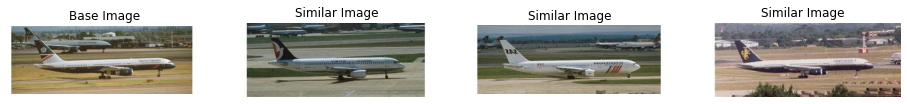

In [39]:
show_images(root_dir)

Not bad)